#Variable pitch solenoid model
###A.M.C. Dawes - 2015
A model to design a variable pitch solenoid and calculate the associated on-axis B-field.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

In [66]:
I = 10 #amps
mu = 4*np.pi*1e-7 #This gives B in units of Tesla

###Parameters:

In [268]:
R = 0.02 #meters
length = 0.15 #meters
c1 = 0.0
c2 = -5.0
c3 = 0.0

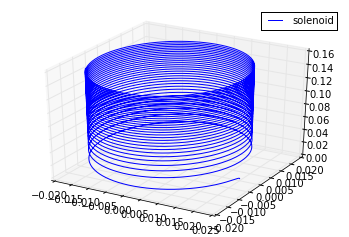

In [269]:

fig = plt.figure()
ax = fig.gca(projection='3d')

p = np.linspace(0, 2 * np.pi, 5000)

theta = c1*p + c2*p**2 + c3*p**3
x = R * np.cos(theta)
y = R * np.sin(theta)
z = p*length/(2*np.pi)  

ax.plot(x, y, z, label='solenoid')
ax.legend()

plt.show()

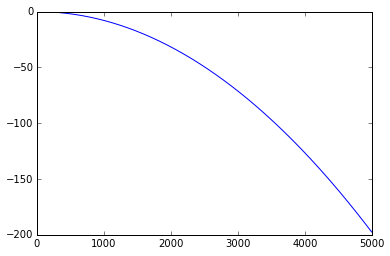

In [270]:
plt.plot(theta)

In [271]:
def B(zprime):
    """Returns B field in Tesla at point zprime on the z-axis"""
    r = np.vstack((x,y,z-zprime)).transpose()
    r_mag = np.sqrt(r[:,0]**2 + r[:,1]**2 + r[:,2]**2)
    r_mag = np.vstack((r_mag,r_mag,r_mag)).transpose()
    dr = r[1:,:] - r[:-1,:]
    drdp = dr/dp
    crossterm = np.cross(drdp,r[:-1,:])
    return mu*I/(4*np.pi) * np.nansum(crossterm / r_mag[:-1,:]**3 * dp,axis=0)

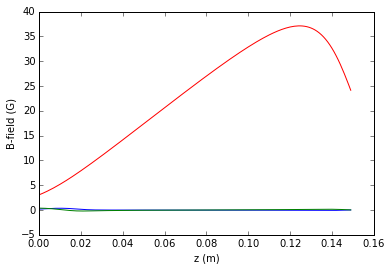

In [272]:
zpoints = np.arange(0,0.15,0.001)
#Bdata = np.zeros((len(zpoints),3))
Bdata = [1e4*B(zpoint) for zpoint in zpoints]

plt.plot(zpoints,Bdata)
plt.ylabel("B-field (G)")
plt.xlabel("z (m)")

##Design discussion and comparison of two methods:
The following are remnants of the design of this notebook but may be useful for verification and testing of the method.

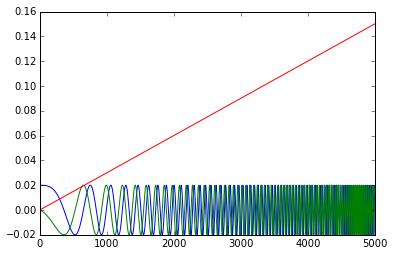

In [266]:
#Calculate r vector:
r = np.vstack((x,y,z)).transpose()
plt.plot(r)

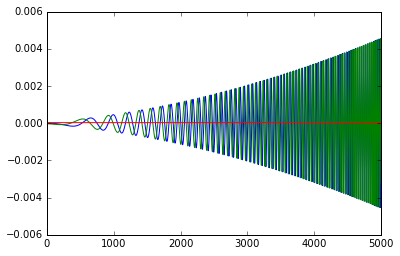

In [267]:
# Calculate dr vector:
dr = r[1:,:] - r[:-1,:]
plt.plot(dr)

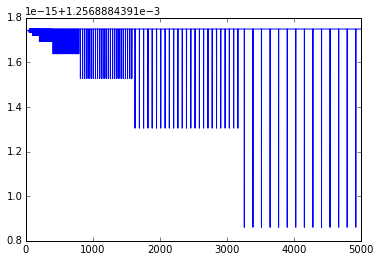

In [148]:
# Calculate dp vector:
dp = p[1:] - p[:-1]
plt.plot(dp)

In [149]:
# or the smart way since p is linear:
dp = p[1] - p[0] 
dp

0.001256888439123742

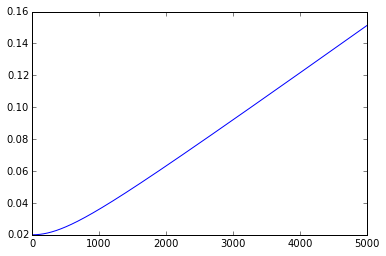

In [150]:
r_mag = np.sqrt(r[:,0]**2 + r[:,1]**2 + r[:,2]**2)
plt.plot(r_mag)

##The new way (as arrays):
Converted the for loops to numpy array-based operations. Usually this just means taking two shifted arrays and subtracting them (for the delta quantities). But we also do some stacking to make the arrays easier to handle. For example, we stack x y and z into the r array. Note, this uses dp, and x,y,z as defined above, all other quantities are calculated in the loop because r is always relative to the point of interest.

In [172]:
def B2(zprime):
    r = np.vstack((x,y,z-zprime)).transpose()
    r_mag = np.sqrt(r[:,0]**2 + r[:,1]**2 + r[:,2]**2)
    r_mag = np.vstack((r_mag,r_mag,r_mag)).transpose()
    dr = r[1:,:] - r[:-1,:]
    drdp = dr/dp
    crossterm = np.cross(drdp,r[:-1,:])
    return mu*I/(4*np.pi) * np.nansum(crossterm / r_mag[:-1,:]**3 * dp,axis=0)

In [173]:
B2list = []
for i in np.arange(0,0.15,0.001):
    B2list.append(B2(i))

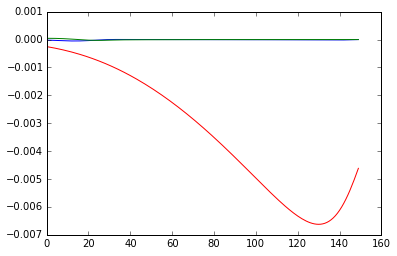

In [174]:
plt.plot(B2list)

##The original way:
Warning, this is slow!

In [175]:
def B(zprime):
    B = 0
    for i in range(len(x)-1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        dz = z[i+1] - z[i]
        dp = p[i+1] - p[i]
        drdp = [dx/dp, dy/dp, dz/dp]
        r = [x[i],y[i],z[i]-zprime]
        r_mag = np.sqrt(x[i]**2 + y[i]**2 + (z[i]-zprime)**2)
        B += mu*I/(4*np.pi) * np.cross(drdp,r) / r_mag**3 * dp
    return B

In [176]:
Blist = []
for i in np.arange(0,0.15,0.001):
    Blist.append(B(i))

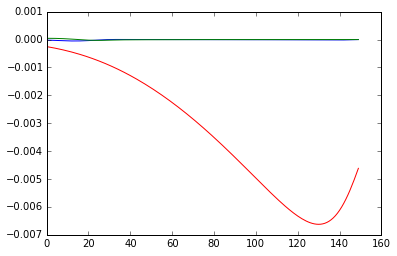

In [177]:
plt.plot(Blist)

##Comparison:
Convert lists to arrays, then plot the difference:

In [178]:
Blist_arr = np.asarray(Blist)
B2list_arr = np.asarray(B2list)

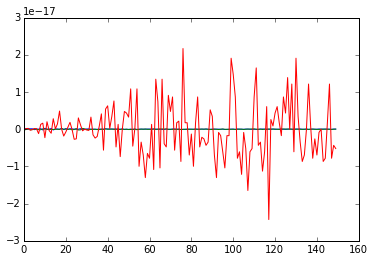

In [179]:
plt.plot(Blist_arr - B2list_arr)

##Conclusion:
The only difference is on the order of $10^{-17}$ so we can ignore it. Furthermore, the difference is primarily in $z$ which we expect as the other dimensions are effectively zero.